Loading image from ../data/3702_left_knee.nii.gz
Image shape: (512, 512, 216)
Image data type: float64
Value range: [(-3024.0, 1769.0)]
Voxel sizes (mm): [0.86914098 0.86914098 2.        ]


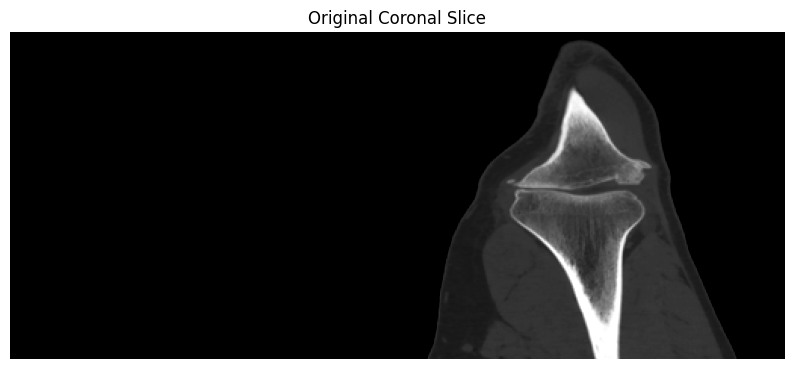

Segmenting knee CT...
Segmentation saved to ../output/original_mask.nii.gz
Expanding segmentation by 2.0 mm (kernel sizes: [3, 3, 1])
Segmentation saved to ../output/expanded_2mm_mask.nii.gz
Expanding segmentation by 4.0 mm (kernel sizes: [5, 5, 2])
Segmentation saved to ../output/expanded_4mm_mask.nii.gz
Generating random mask with randomization factor: 0.65
Segmentation saved to ../output/random_mask_1.nii.gz
Generating random mask with randomization factor: 0.4
Segmentation saved to ../output/random_mask_2.nii.gz

Processing tibia points for Original...
Finding lowest points on tibia surface...
Tibia Medial lowest point (mm): [341.57240617 222.50009155 158.        ]
Tibia Lateral lowest point (mm): [312.02161276 222.50009155 158.        ]
Tibia Medial lowest point (voxel): (393, 256, 79)
Tibia Lateral lowest point (voxel): (359, 256, 79)

Processing tibia points for Expanded 2mm...
Finding lowest points on tibia surface...
Tibia Medial lowest point (mm): [340.70326519 222.50009155 1

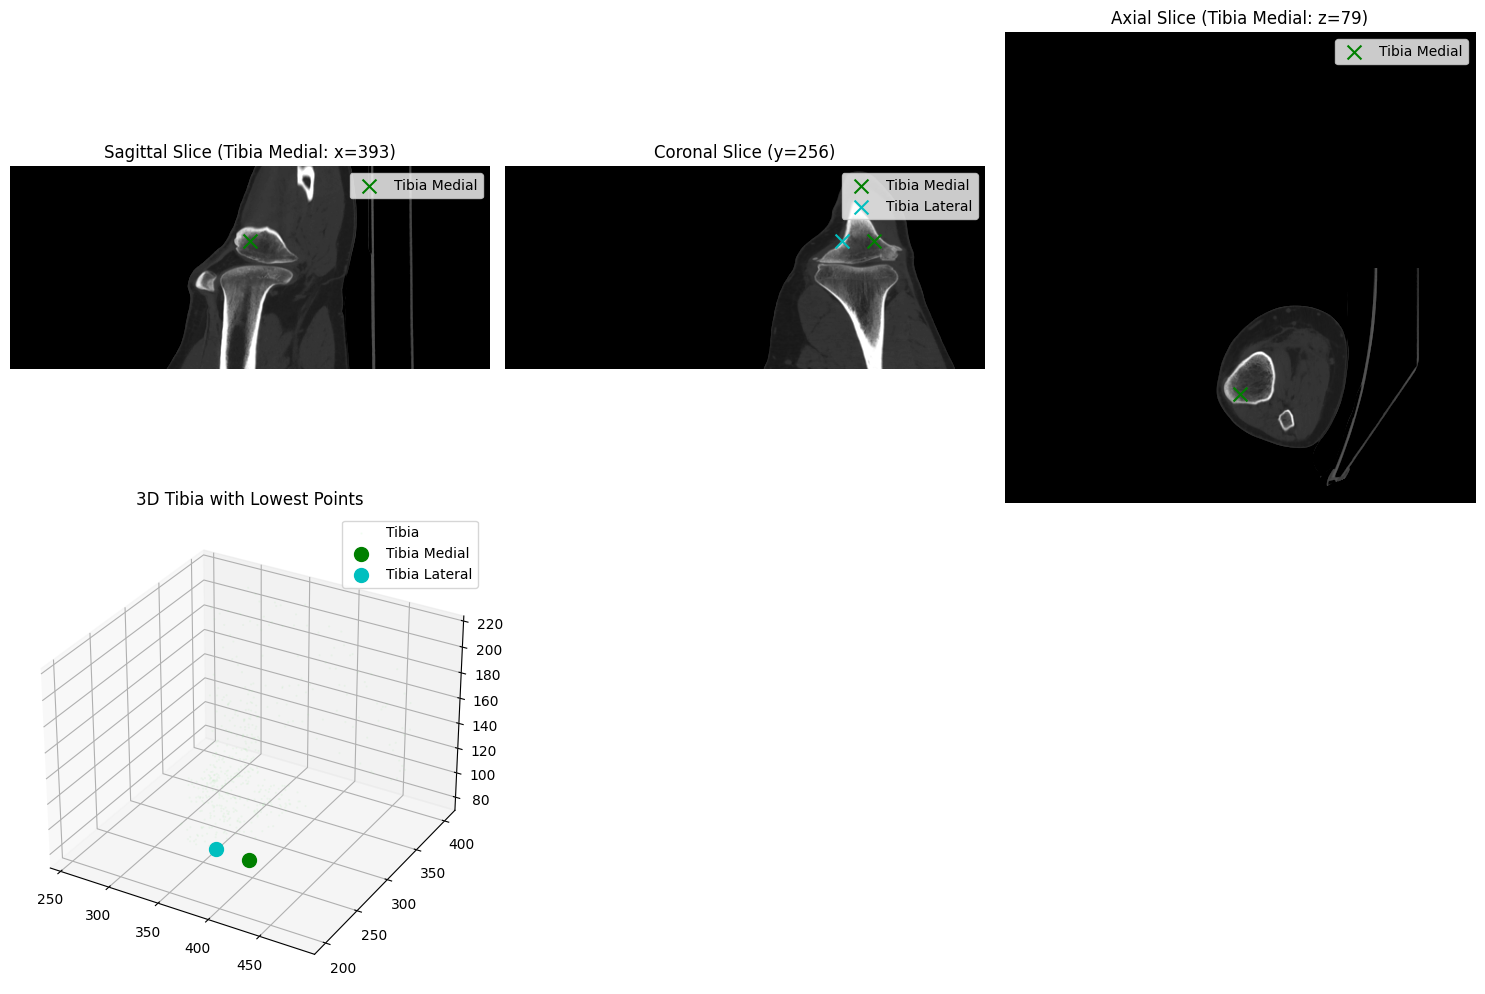

Tibia points visualization for all masks saved to tibia_points_all_masks.png


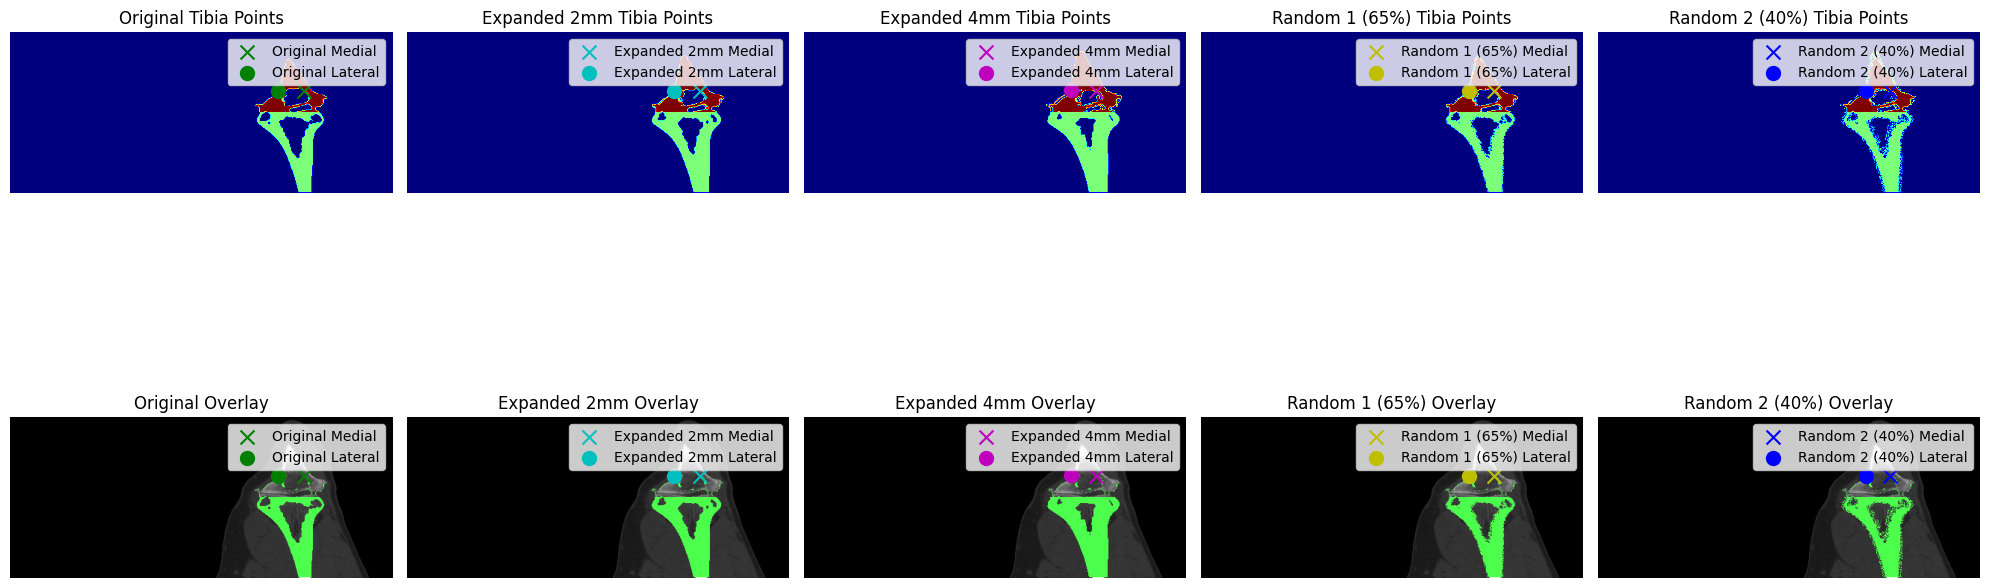

All segmentations visualization saved to segmentations_2mm_group.png


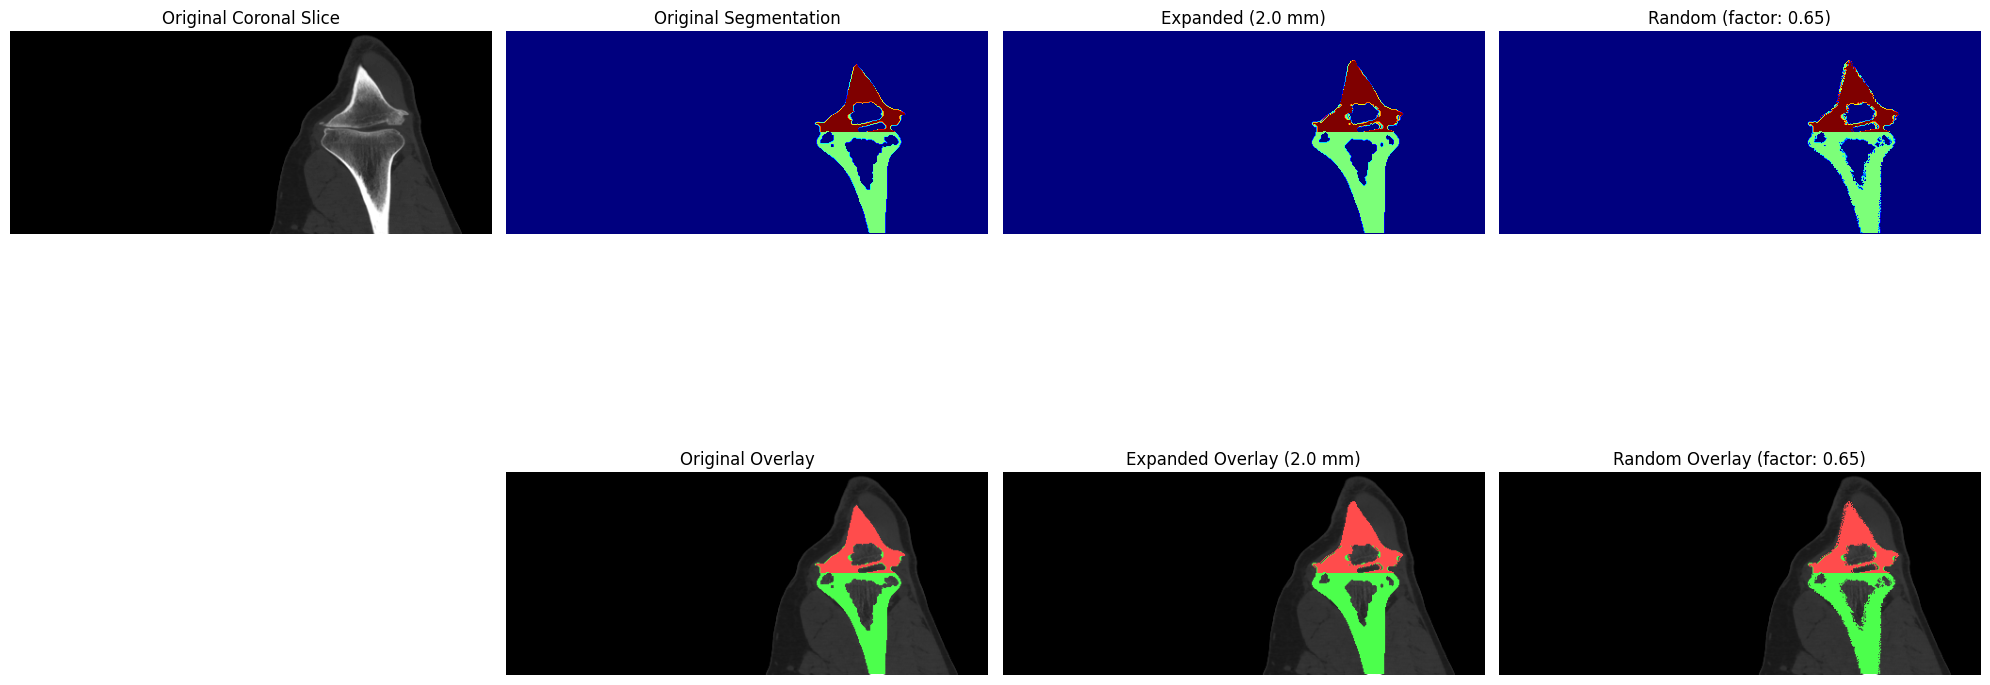

All segmentations visualization saved to segmentations_4mm_group.png


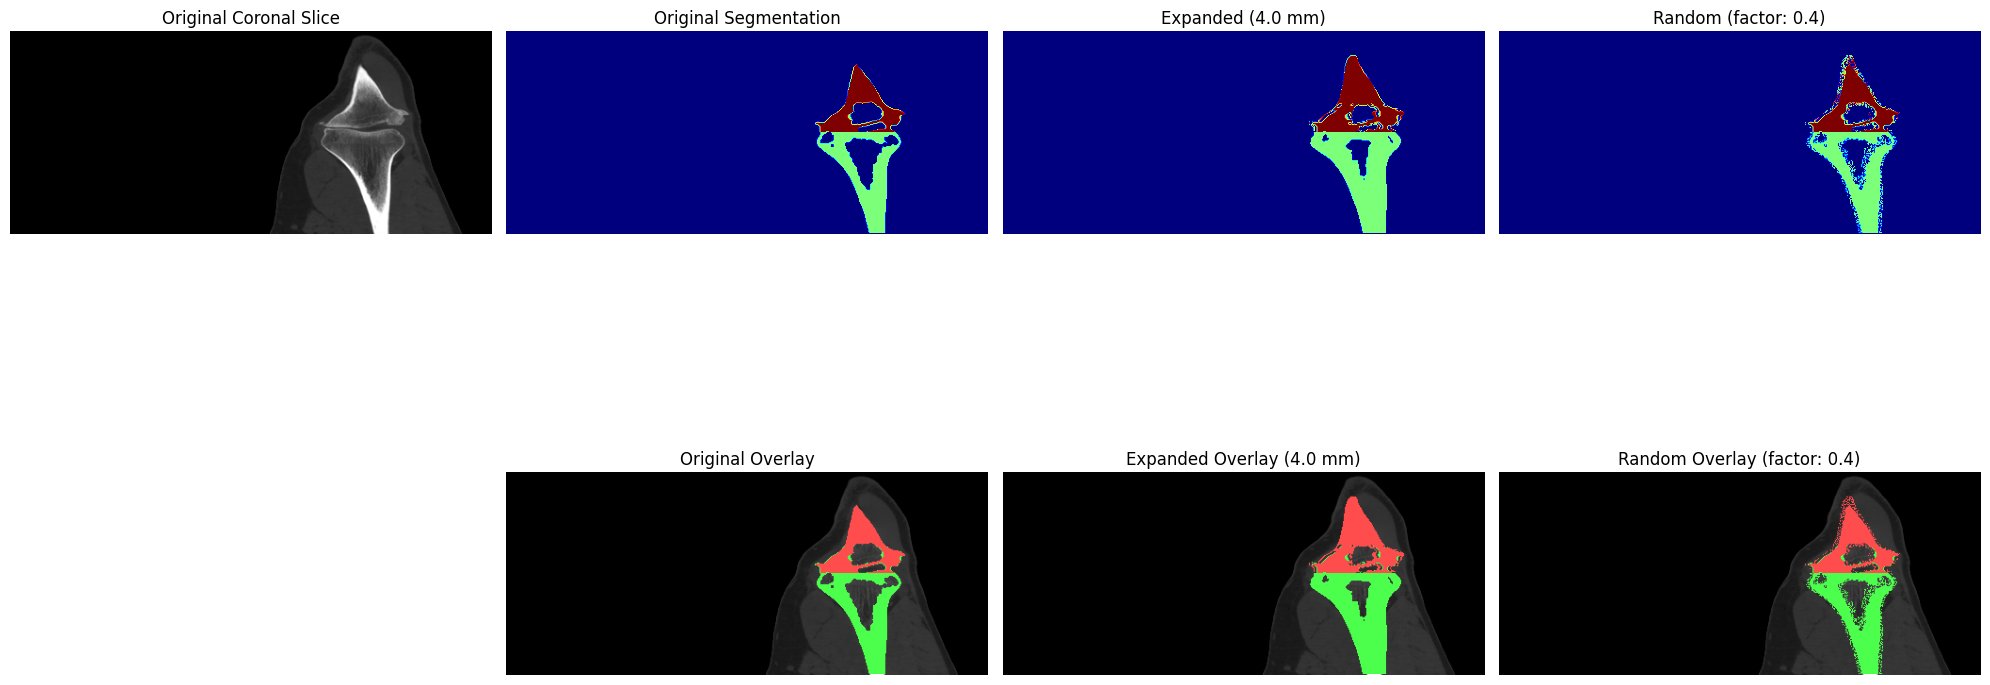

Segmentation visualization saved to knee_segmentation_original.png


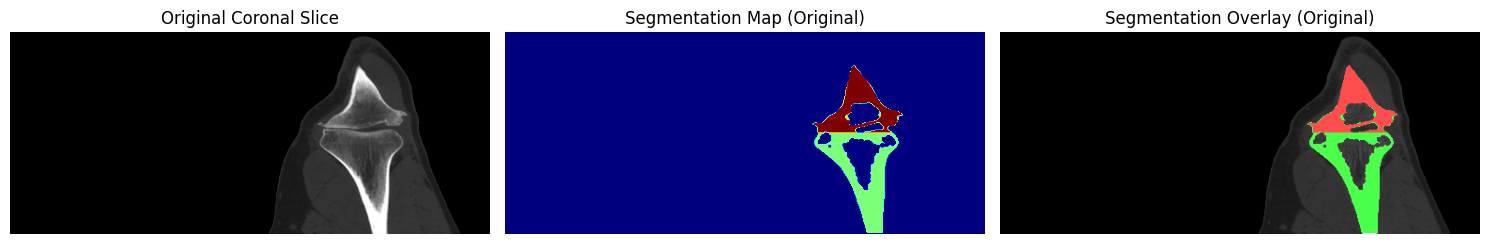

Segmentation visualization saved to knee_segmentation_expanded_2mm.png


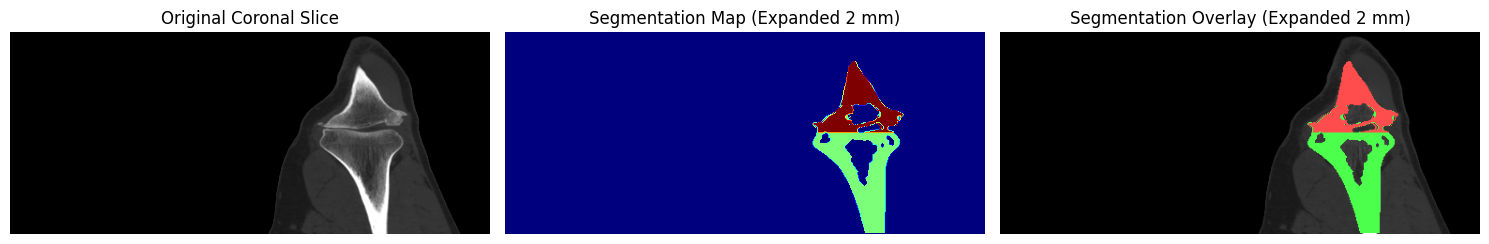

Segmentation visualization saved to knee_segmentation_expanded_4mm.png


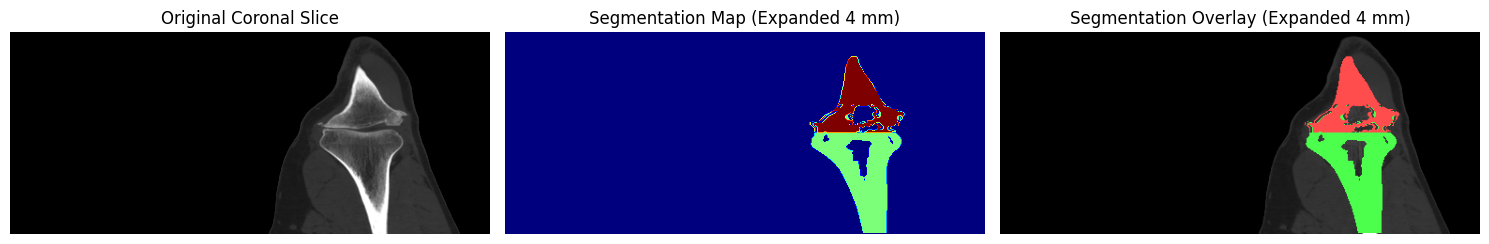

Segmentation visualization saved to knee_segmentation_random_1.png


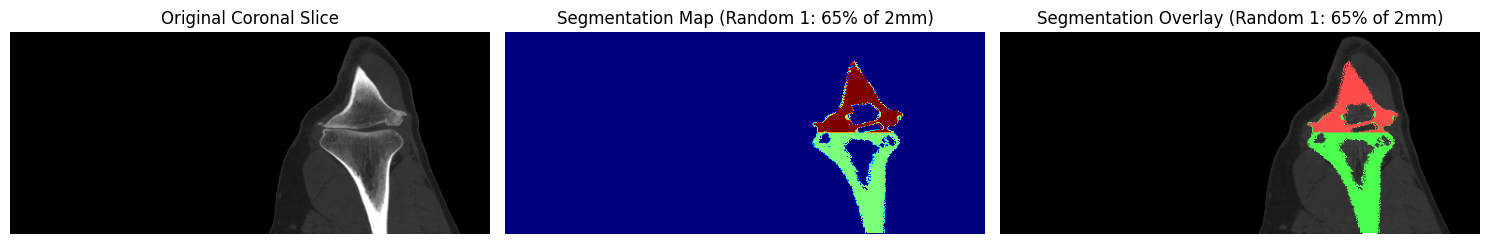

Segmentation visualization saved to knee_segmentation_random_2.png


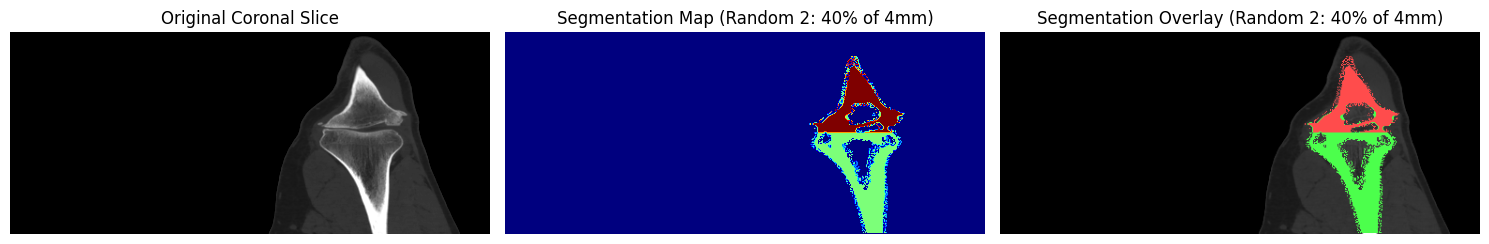

Original tibia volume: 274610 voxels (label 1, green)
Original femur volume: 244016 voxels (label 2, red)
2mm Expanded tibia volume: 381908 voxels
2mm Expanded femur volume: 355065 voxels
2mm Expansion ratio: Tibia 1.39x, Femur 1.46x
4mm Expanded tibia volume: 496266 voxels
4mm Expanded femur volume: 478570 voxels
4mm Expansion ratio: Tibia 1.81x, Femur 1.96x
Random 1 tibia volume: 344321 voxels
Random 1 femur volume: 316162 voxels
Random 1 ratio: Tibia 1.25x, Femur 1.30x
Random 2 tibia volume: 363316 voxels
Random 2 femur volume: 337956 voxels
Random 2 ratio: Tibia 1.32x, Femur 1.38x

TIBIA LOWEST POINTS SUMMARY:

Original:
  Medial lowest point (mm): [341.57240617 222.50009155 158.        ]
  Lateral lowest point (mm): [312.02161276 222.50009155 158.        ]
  Medial lowest point (voxel): (393, 256, 79)
  Lateral lowest point (voxel): (359, 256, 79)

Expanded 2mm:
  Medial lowest point (mm): [340.70326519 222.50009155 158.        ]
  Lateral lowest point (mm): [311.15247178 221.6309

In [3]:
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from scipy import ndimage
from skimage import morphology

def load_nifti_image(input_path):
    """Load NIfTI image and return data, image object, and voxel sizes."""
    print(f"Loading image from {input_path}")
    img = nib.load(input_path)
    data = img.get_fdata()
    voxel_sizes = np.abs(img.affine.diagonal()[:3])  # Voxel sizes in mm (x, y, z)
    
    print(f"Image shape: {data.shape}")
    print(f"Image data type: {data.dtype}")
    print(f"Value range: [{np.min(data), np.max(data)}]")
    print(f"Voxel sizes (mm): {voxel_sizes}")
    
    return data, img, voxel_sizes

def display_coronal_slice(data, title="Original Coronal Slice"):
    """Display the middle coronal slice of the volume."""
    coronal_idx = data.shape[1] // 2
    coronal_slice = data[:, coronal_idx, :].T
    
    plt.figure(figsize=(10, 10))
    plt.imshow(coronal_slice, cmap='gray', vmin=-300, vmax=1500)
    plt.title(title)
    plt.axis('off')
    plt.show()

def create_bone_mask(slice_data, bone_threshold=200, min_size=50):
    """Create a binary mask for bones in a single slice."""
    bone_mask = slice_data > bone_threshold
    bone_mask = morphology.remove_small_objects(bone_mask, min_size=min_size)
    bone_mask = morphology.binary_closing(bone_mask, morphology.disk(2))
    return bone_mask

def find_joint_position(bone_mask, height):
    """Find the approximate joint position in a slice."""
    vertical_profile = np.sum(bone_mask, axis=0)
    smooth_profile = ndimage.gaussian_filter1d(vertical_profile, sigma=5)
    
    middle_start = height // 3
    middle_end = 2 * height // 3
    middle_profile = smooth_profile[middle_start:middle_end]
    
    if len(middle_profile) > 5:
        min_indices = [
            j for j in range(2, len(middle_profile) - 2)
            if middle_profile[j] < middle_profile[j-1] and middle_profile[j] < middle_profile[j+1]
        ]
        if min_indices:
            joint_idx = min_indices[np.argmin([middle_profile[j] for j in min_indices])]
            return middle_start + joint_idx
    return height // 2  # Fallback to middle point

def segment_slice(slice_data, bone_threshold=200):
    """Segment a single slice into femur and tibia."""
    height = slice_data.shape[1]
    bone_mask = create_bone_mask(slice_data, bone_threshold)
    
    if np.max(slice_data) < bone_threshold:
        return None, None
    
    joint_position = find_joint_position(bone_mask, height)
    
    femur_mask = bone_mask.copy()
    femur_mask[:, joint_position:] = False
    femur_mask = morphology.remove_small_objects(femur_mask, min_size=100)
    
    tibia_mask = bone_mask.copy()
    tibia_mask[:, :joint_position] = False
    tibia_mask = morphology.remove_small_objects(tibia_mask, min_size=100)
    
    return femur_mask, tibia_mask

def apply_3d_postprocessing(segmentation_volume):
    """Apply 3D post-processing to smooth and refine segmentation."""
    tibia_seg = segmentation_volume == 1
    femur_seg = segmentation_volume == 2
    
    struct_element = np.ones((3, 3, 3))
    tibia_seg = ndimage.binary_fill_holes(tibia_seg)
    femur_seg = ndimage.binary_fill_holes(femur_seg)
    tibia_seg = ndimage.binary_closing(tibia_seg, structure=struct_element)
    femur_seg = ndimage.binary_closing(femur_seg, structure=struct_element)
    tibia_seg = morphology.remove_small_objects(tibia_seg, min_size=1000)
    femur_seg = morphology.remove_small_objects(femur_seg, min_size=1000)
    
    result = np.zeros_like(segmentation_volume)
    result[tibia_seg] = 1
    result[femur_seg] = 2
    return result

def expand_segmentation(segmentation_volume, voxel_sizes, expansion_mm=2.0):
    """Expand tibia and femur masks by a specified distance in mm."""
    kernel_sizes = [int(np.ceil(expansion_mm / vs)) for vs in voxel_sizes]
    kernel_sizes = [max(1, ks) for ks in kernel_sizes]
    print(f"Expanding segmentation by {expansion_mm} mm (kernel sizes: {kernel_sizes})")
    
    struct_element = np.ones(tuple(kernel_sizes))
    tibia_seg = segmentation_volume == 1
    femur_seg = segmentation_volume == 2
    
    tibia_expanded = ndimage.binary_dilation(tibia_seg, structure=struct_element)
    femur_expanded = ndimage.binary_dilation(femur_seg, structure=struct_element)
    
    overlap = tibia_expanded & femur_expanded
    tibia_expanded[overlap] = tibia_seg[overlap]
    femur_expanded[overlap] = femur_seg[overlap]
    
    result = np.zeros_like(segmentation_volume)
    result[tibia_expanded] = 1
    result[femur_expanded] = 2
    return result

def generate_random_mask(original_segmentation, expanded_segmentation, random_value=0.5):
    """Generate a random mask between the original and expanded segmentations."""
    random_value = max(0.0, min(1.0, random_value))
    print(f"Generating random mask with randomization factor: {random_value}")
    
    result = np.zeros_like(original_segmentation)
    
    for label in [1, 2]:
        original_label_mask = original_segmentation == label
        expanded_label_mask = expanded_segmentation == label
        
        expansion_region = expanded_label_mask & ~original_label_mask
        
        expansion_size = np.sum(expansion_region)
        if expansion_size > 0:
            random_mask = np.random.random(expansion_size) < random_value
            temp_expansion = np.zeros_like(expansion_region, dtype=bool)
            temp_expansion[expansion_region] = random_mask
            result[original_label_mask | temp_expansion] = label
        else:
            result[original_label_mask] = label
    
    return result

def fallback_segmentation(data, start_slice, end_slice):
    """Apply fallback segmentation method for low bone volume cases."""
    segmentation_volume = np.zeros_like(data)
    
    for i in range(start_slice, end_slice):
        slice_data = data[:, i, :]
        bone_mask = slice_data > 150
        height = slice_data.shape[1]
        mid_point = height // 2
        
        femur_mask = bone_mask.copy()
        femur_mask[:, mid_point:] = False
        femur_mask = morphology.remove_small_objects(femur_mask, min_size=50)
        
        tibia_mask = bone_mask.copy()
        tibia_mask[:, :mid_point] = False
        tibia_mask = morphology.remove_small_objects(tibia_mask, min_size=50)
        
        segmentation_volume[:, i, :][tibia_mask] = 1
        segmentation_volume[:, i, :][femur_mask] = 2
    
    struct_element = np.ones((5, 5, 5))
    tibia_seg = ndimage.binary_closing(segmentation_volume == 1, structure=struct_element)
    femur_seg = ndimage.binary_closing(segmentation_volume == 2, structure=struct_element)
    tibia_seg = ndimage.binary_fill_holes(tibia_seg)
    femur_seg = ndimage.binary_fill_holes(femur_seg)
    tibia_seg = morphology.remove_small_objects(tibia_seg, min_size=1000)
    femur_seg = morphology.remove_small_objects(femur_seg, min_size=1000)
    
    result = np.zeros_like(data)
    result[tibia_seg] = 1
    result[femur_seg] = 2
    return result

def visualize_segmentation(data, segmentation_volume, output_file='knee_segmentation.png', show_plot=True, 
                          title_suffix='', color_map='jet'):
    """Visualize segmentation overlay for given segmentation volume."""
    try:
        if show_plot:
            import matplotlib
            if matplotlib.get_backend().lower() in ['agg', 'cairo', 'ps', 'pdf']:
                print("Warning: Non-interactive backend detected. Switching to 'TkAgg' for display.")
                matplotlib.use('TkAgg')
        
        mid_slice = data.shape[1] // 2
        
        plt.figure(figsize=(15, 5))
        
        plt.subplot(1, 3, 1)
        plt.imshow(data[:, mid_slice, :].T, cmap='gray', vmin=-300, vmax=1500)
        plt.title('Original Coronal Slice')
        plt.axis('off')
        
        plt.subplot(1, 3, 2)
        plt.imshow(segmentation_volume[:, mid_slice, :].T, cmap=color_map)
        plt.title(f'Segmentation Map {title_suffix}')
        plt.axis('off')
        
        plt.subplot(1, 3, 3)
        overlay = np.zeros((*data[:, mid_slice, :].T.shape, 3))
        orig_slice = data[:, mid_slice, :].T
        orig_norm = np.clip(orig_slice, -300, 1500)
        orig_norm = (orig_norm - (-300)) / (1500 - (-300))
        
        overlay[:, :, 0] = orig_norm
        overlay[:, :, 1] = orig_norm
        overlay[:, :, 2] = orig_norm
        
        tibia_mask = segmentation_volume[:, mid_slice, :].T == 1
        femur_mask = segmentation_volume[:, mid_slice, :].T == 2
        
        overlay[femur_mask, 0] = 1.0
        overlay[femur_mask, 1] = 0.3
        overlay[femur_mask, 2] = 0.3
        overlay[tibia_mask, 0] = 0.3
        overlay[tibia_mask, 1] = 1.0
        overlay[tibia_mask, 2] = 0.3
        
        plt.imshow(overlay)
        plt.title(f'Segmentation Overlay {title_suffix}')
        plt.axis('off')
        
        plt.tight_layout()
        plt.savefig(output_file)
        print(f"Segmentation visualization saved to {output_file}")
        
        if show_plot:
            plt.show()
        else:
            plt.close()
                
    except Exception as e:
        print(f"Error during visualization: {e}")
        print("Visualization skipped. Check if matplotlib is properly installed and configured.")
        plt.close()

def visualize_all_segmentations(data, original_seg, expanded_seg, random_seg, 
                               output_file='all_segmentations.png', show_plot=True,
                               expansion_mm=2.0, random_value=0.5):
    """Visualize all three segmentation types side by side."""
    try:
        if show_plot:
            import matplotlib
            if matplotlib.get_backend().lower() in ['agg', 'cairo', 'ps', 'pdf']:
                print("Warning: Non-interactive backend detected. Switching to 'TkAgg' for display.")
                matplotlib.use('TkAgg')
        
        mid_slice = data.shape[1] // 2
        
        orig_slice = data[:, mid_slice, :].T
        orig_norm = np.clip(orig_slice, -300, 1500)
        orig_norm = (orig_norm - (-300)) / (1500 - (-300))
        
        plt.figure(figsize=(20, 10))
        
        plt.subplot(2, 4, 1)
        plt.imshow(orig_norm, cmap='gray')
        plt.title('Original Coronal Slice')
        plt.axis('off')
        
        plt.subplot(2, 4, 2)
        plt.imshow(original_seg[:, mid_slice, :].T, cmap='jet')
        plt.title('Original Segmentation')
        plt.axis('off')
        
        plt.subplot(2, 4, 3)
        plt.imshow(expanded_seg[:, mid_slice, :].T, cmap='jet')
        plt.title(f'Expanded ({expansion_mm} mm)')
        plt.axis('off')
        
        plt.subplot(2, 4, 4)
        plt.imshow(random_seg[:, mid_slice, :].T, cmap='jet')
        plt.title(f'Random (factor: {random_value})')
        plt.axis('off')
        
        plt.subplot(2, 4, 6)
        orig_overlay = np.zeros((*orig_norm.shape, 3))
        orig_overlay[:, :, 0] = orig_norm
        orig_overlay[:, :, 1] = orig_norm
        orig_overlay[:, :, 2] = orig_norm
        
        tibia_mask = original_seg[:, mid_slice, :].T == 1
        femur_mask = original_seg[:, mid_slice, :].T == 2
        
        orig_overlay[femur_mask, 0] = 1.0
        orig_overlay[femur_mask, 1] = 0.3
        orig_overlay[femur_mask, 2] = 0.3
        orig_overlay[tibia_mask, 0] = 0.3
        orig_overlay[tibia_mask, 1] = 1.0
        orig_overlay[tibia_mask, 2] = 0.3
        
        plt.imshow(orig_overlay)
        plt.title('Original Overlay')
        plt.axis('off')
        
        plt.subplot(2, 4, 7)
        exp_overlay = np.zeros((*orig_norm.shape, 3))
        exp_overlay[:, :, 0] = orig_norm
        exp_overlay[:, :, 1] = orig_norm
        exp_overlay[:, :, 2] = orig_norm
        
        tibia_mask = expanded_seg[:, mid_slice, :].T == 1
        femur_mask = expanded_seg[:, mid_slice, :].T == 2
        
        exp_overlay[femur_mask, 0] = 1.0
        exp_overlay[femur_mask, 1] = 0.3
        exp_overlay[femur_mask, 2] = 0.3
        exp_overlay[tibia_mask, 0] = 0.3
        exp_overlay[tibia_mask, 1] = 1.0
        exp_overlay[tibia_mask, 2] = 0.3
        
        plt.imshow(exp_overlay)
        plt.title(f'Expanded Overlay ({expansion_mm} mm)')
        plt.axis('off')
        
        plt.subplot(2, 4, 8)
        rand_overlay = np.zeros((*orig_norm.shape, 3))
        rand_overlay[:, :, 0] = orig_norm
        rand_overlay[:, :, 1] = orig_norm
        rand_overlay[:, :, 2] = orig_norm
        
        tibia_mask = random_seg[:, mid_slice, :].T == 1
        femur_mask = random_seg[:, mid_slice, :].T == 2
        
        rand_overlay[femur_mask, 0] = 1.0
        rand_overlay[femur_mask, 1] = 0.3
        rand_overlay[femur_mask, 2] = 0.3
        rand_overlay[tibia_mask, 0] = 0.3
        rand_overlay[tibia_mask, 1] = 1.0
        rand_overlay[tibia_mask, 2] = 0.3
        
        plt.imshow(rand_overlay)
        plt.title(f'Random Overlay (factor: {random_value})')
        plt.axis('off')
        
        plt.tight_layout()
        plt.savefig(output_file)
        print(f"All segmentations visualization saved to {output_file}")
        
        if show_plot:
            plt.show()
        else:
            plt.close()
    
    except Exception as e:
        print(f"Error during visualization: {e}")
        print("Visualization skipped. Check if matplotlib is properly installed and configured.")
        plt.close()

def save_segmentation(segmentation_volume, img, output_path):
    """Save segmentation volume as NIfTI file."""
    segmentation_nifti = nib.Nifti1Image(segmentation_volume.astype(np.int16), img.affine, img.header)
    segmentation_nifti.header.set_data_dtype(np.int16)
    nib.save(segmentation_nifti, output_path)
    print(f"Segmentation saved to {output_path}")

def find_tibia_lowest_points(segmentation_volume, voxel_sizes):
    """Find the medial and lateral lowest points on the tibia surface."""
    print("Finding lowest points on tibia surface...")
    
    tibia_mask = segmentation_volume == 1
    
    if np.sum(tibia_mask) == 0:
        print("No tibia detected in the segmentation.")
        return None, None, None, None
    
    tibia_indices = np.where(tibia_mask)
    
    tibia_points = np.array([tibia_indices[0] * voxel_sizes[0], 
                             tibia_indices[1] * voxel_sizes[1],
                             tibia_indices[2] * voxel_sizes[2]]).T
    
    center_x = np.mean(tibia_points[:, 0])
    
    lateral_mask = tibia_points[:, 0] < center_x
    medial_mask = tibia_points[:, 0] >= center_x
    
    lateral_points = tibia_points[lateral_mask]
    medial_points = tibia_points[medial_mask]
    
    if len(lateral_points) > 0:
        lateral_lowest_idx = np.argmin(lateral_points[:, 2])
        lateral_lowest = lateral_points[lateral_lowest_idx]
    else:
        lateral_lowest = None
        
    if len(medial_points) > 0:
        medial_lowest_idx = np.argmin(medial_points[:, 2])
        medial_lowest = medial_points[medial_lowest_idx]
    else:
        medial_lowest = None
    
    if lateral_lowest is not None:
        lateral_voxel = (
            int(lateral_lowest[0] / voxel_sizes[0]),
            int(lateral_lowest[1] / voxel_sizes[1]),
            int(lateral_lowest[2] / voxel_sizes[2])
        )
    else:
        lateral_voxel = None
        
    if medial_lowest is not None:
        medial_voxel = (
            int(medial_lowest[0] / voxel_sizes[0]),
            int(medial_lowest[1] / voxel_sizes[1]),
            int(medial_lowest[2] / voxel_sizes[2])
        )
    else:
        medial_voxel = None
    
    print(f"Tibia Medial lowest point (mm): {medial_lowest}")
    print(f"Tibia Lateral lowest point (mm): {lateral_lowest}")
    print(f"Tibia Medial lowest point (voxel): {medial_voxel}")
    print(f"Tibia Lateral lowest point (voxel): {lateral_voxel}")
    
    return medial_lowest, lateral_lowest, medial_voxel, lateral_voxel

def visualize_tibia_points(data, segmentation_volume, tibia_medial_voxel, tibia_lateral_voxel, 
                          output_file='tibia_lowest_points.png', show_plot=True):
    """Visualize the medial and lateral lowest points on the tibia."""
    if tibia_medial_voxel is None or tibia_lateral_voxel is None:
        print("Cannot visualize tibia lowest points - missing coordinates.")
        return
    
    try:
        if show_plot:
            import matplotlib
            if matplotlib.get_backend().lower() in ['agg', 'cairo', 'ps', 'pdf']:
                print("Warning: Non-interactive backend detected. Switching to 'TkAgg' for display.")
                matplotlib.use('TkAgg')
        
        plt.figure(figsize=(15, 10))
        
        tm_x, tm_y, tm_z = tibia_medial_voxel
        tl_x, tl_y, tl_z = tibia_lateral_voxel
        
        avg_y = (tm_y + tl_y) // 2
        
        plt.subplot(2, 3, 1)
        plt.imshow(data[tm_x, :, :].T, cmap='gray', vmin=-300, vmax=1500)
        plt.scatter(tm_y, tm_z, c='g', marker='x', s=100, label='Tibia Medial')
        plt.title(f'Sagittal Slice (Tibia Medial: x={tm_x})')
        plt.legend()
        plt.axis('off')
        
        plt.subplot(2, 3, 2)
        plt.imshow(data[:, avg_y, :].T, cmap='gray', vmin=-300, vmax=1500)
        plt.scatter(tm_x, tm_z, c='g', marker='x', s=100, label='Tibia Medial')
        plt.scatter(tl_x, tl_z, c='c', marker='x', s=100, label='Tibia Lateral')
        plt.title(f'Coronal Slice (y={avg_y})')
        plt.legend()
        plt.axis('off')
        
        plt.subplot(2, 3, 3)
        plt.imshow(data[:, :, tm_z], cmap='gray', vmin=-300, vmax=1500)
        plt.scatter(tm_y, tm_x, c='g', marker='x', s=100, label='Tibia Medial')
        plt.title(f'Axial Slice (Tibia Medial: z={tm_z})')
        plt.legend()
        plt.axis('off')
        
        ax = plt.subplot(2, 3, 4, projection='3d')
        tibia_coords = np.where(segmentation_volume == 1)
        
        sample_rate = max(1, len(tibia_coords[0]) // 500)
        tx = tibia_coords[0][::sample_rate]
        ty = tibia_coords[1][::sample_rate]
        tz = tibia_coords[2][::sample_rate]
        
        ax.scatter(tx, ty, tz, c='lightgreen', alpha=0.1, marker='.', s=1, label='Tibia')
        ax.scatter([tm_x], [tm_y], [tm_z], c='g', marker='o', s=100, label='Tibia Medial')
        ax.scatter([tl_x], [tl_y], [tl_z], c='c', marker='o', s=100, label='Tibia Lateral')
        ax.set_title('3D Tibia with Lowest Points')
        ax.legend()
        
        plt.tight_layout()
        plt.savefig(output_file)
        print(f"Tibia lowest points visualization saved to {output_file}")
        
        if show_plot:
            plt.show()
        else:
            plt.close()
            
    except Exception as e:
        print(f"Error during tibia points visualization: {e}")
        print("Visualization skipped.")
        plt.close()

def visualize_tibia_points_all_masks(data, masks, tibia_points, output_file='tibia_points_all_masks.png', show_plot=True):
    """Visualize tibia medial and lateral lowest points for all segmentation masks."""
    try:
        if show_plot:
            import matplotlib
            if matplotlib.get_backend().lower() in ['agg', 'cairo', 'ps', 'pdf']:
                print("Warning: Non-interactive backend detected. Switching to 'TkAgg' for display.")
                matplotlib.use('TkAgg')
        
        plt.figure(figsize=(20, 10))
        
        mask_names = ['Original', 'Expanded 2mm', 'Expanded 4mm', 'Random 1 (65%)', 'Random 2 (40%)']
        colors = ['g', 'c', 'm', 'y', 'b']
        
        mid_slice = data.shape[1] // 2
        orig_slice = data[:, mid_slice, :].T
        orig_norm = np.clip(orig_slice, -300, 1500)
        orig_norm = (orig_norm - (-300)) / (1500 - (-300))
        
        for i, (mask_name, mask, color) in enumerate(zip(mask_names, masks, colors)):
            medial_voxel = tibia_points[mask_name]['medial_voxel']
            lateral_voxel = tibia_points[mask_name]['lateral_voxel']
            
            if medial_voxel is None or lateral_voxel is None:
                print(f"Skipping visualization for {mask_name} - missing tibia points.")
                continue
            
            mx, my, mz = medial_voxel
            lx, ly, lz = lateral_voxel
            
            plt.subplot(2, 5, i + 1)
            plt.imshow(mask[:, mid_slice, :].T, cmap='jet')
            plt.scatter(mx, mz, c=color, marker='x', s=100, label=f'{mask_name} Medial')
            plt.scatter(lx, lz, c=color, marker='o', s=100, label=f'{mask_name} Lateral')
            plt.title(f'{mask_name} Tibia Points')
            plt.legend()
            plt.axis('off')
            
            plt.subplot(2, 5, i + 6)
            overlay = np.zeros((*orig_norm.shape, 3))
            overlay[:, :, 0] = orig_norm
            overlay[:, :, 1] = orig_norm
            overlay[:, :, 2] = orig_norm
            
            tibia_mask = mask[:, mid_slice, :].T == 1
            overlay[tibia_mask, 0] = 0.3
            overlay[tibia_mask, 1] = 1.0
            overlay[tibia_mask, 2] = 0.3
            
            plt.imshow(overlay)
            plt.scatter(mx, mz, c=color, marker='x', s=100, label=f'{mask_name} Medial')
            plt.scatter(lx, lz, c=color, marker='o', s=100, label=f'{mask_name} Lateral')
            plt.title(f'{mask_name} Overlay')
            plt.legend()
            plt.axis('off')
        
        plt.tight_layout()
        plt.savefig(output_file)
        print(f"Tibia points visualization for all masks saved to {output_file}")
        
        if show_plot:
            plt.show()
        else:
            plt.close()
            
    except Exception as e:
        print(f"Error during tibia points visualization: {e}")
        print("Visualization skipped.")
        plt.close()

def segment_knee(input_path, output_paths=None, show_plots=True):
    """Segment the femur and tibia, save masks, and find lowest points on tibia for all masks."""
    if not os.path.exists(input_path):
        raise FileNotFoundError(f"Input file {input_path} does not exist.")
    
    if output_paths is None:
        output_dir = os.path.dirname(input_path) or '.'
        output_paths = {
            'original': os.path.join(output_dir, 'original_mask.nii.gz'),
            'expanded_2mm': os.path.join(output_dir, 'expanded_2mm_mask.nii.gz'),
            'expanded_4mm': os.path.join(output_dir, 'expanded_4mm_mask.nii.gz'),
            'random_1': os.path.join(output_dir, 'random_mask_1.nii.gz'),
            'random_2': os.path.join(output_dir, 'random_mask_2.nii.gz')
        }
    
    for path in output_paths.values():
        os.makedirs(os.path.dirname(path), exist_ok=True)
    
    data, img, voxel_sizes = load_nifti_image(input_path)
    if show_plots:
        display_coronal_slice(data)
    
    segmentation_volume = np.zeros_like(data)
    start_slice = int(data.shape[1] * 0.2)
    end_slice = int(data.shape[1] * 0.8)
    
    print("Segmenting knee CT...")
    for i in range(start_slice, end_slice):
        femur_mask, tibia_mask = segment_slice(data[:, i, :])
        if femur_mask is not None and tibia_mask is not None:
            segmentation_volume[:, i, :][tibia_mask] = 1
            segmentation_volume[:, i, :][femur_mask] = 2
    
    segmentation_volume = apply_3d_postprocessing(segmentation_volume)
    
    original_segmentation = segmentation_volume.copy()
    save_segmentation(original_segmentation, img, output_paths['original'])
    
    tibia_volume = np.sum(segmentation_volume == 1)
    femur_volume = np.sum(segmentation_volume == 2)
    
    if tibia_volume < 1000 or femur_volume < 1000:
        print("Warning: Insufficient bone volume detected. Applying fallback method...")
        segmentation_volume = fallback_segmentation(data, start_slice, end_slice)
        original_segmentation = segmentation_volume.copy()
        save_segmentation(original_segmentation, img, output_paths['original'])
    
    expanded_2mm = expand_segmentation(original_segmentation, voxel_sizes, expansion_mm=2.0)
    save_segmentation(expanded_2mm, img, output_paths['expanded_2mm'])
    
    expanded_4mm = expand_segmentation(original_segmentation, voxel_sizes, expansion_mm=4.0)
    save_segmentation(expanded_4mm, img, output_paths['expanded_4mm'])
    
    random_1 = generate_random_mask(original_segmentation, expanded_2mm, random_value=0.65)
    save_segmentation(random_1, img, output_paths['random_1'])
    
    random_2 = generate_random_mask(original_segmentation, expanded_4mm, random_value=0.40)
    save_segmentation(random_2, img, output_paths['random_2'])
    
    # Find lowest points on tibia for all masks
    masks = {
        'Original': original_segmentation,
        'Expanded 2mm': expanded_2mm,
        'Expanded 4mm': expanded_4mm,
        'Random 1 (65%)': random_1,
        'Random 2 (40%)': random_2
    }
    tibia_points = {}
    for mask_name, mask in masks.items():
        print(f"\nProcessing tibia points for {mask_name}...")
        medial_mm, lateral_mm, medial_voxel, lateral_voxel = find_tibia_lowest_points(mask, voxel_sizes)
        tibia_points[mask_name] = {
            'medial_point_mm': medial_mm,
            'lateral_point_mm': lateral_mm,
            'medial_voxel': medial_voxel,
            'lateral_voxel': lateral_voxel
        }
    
    # Visualize tibia points for original mask
    visualize_tibia_points(
        data, original_segmentation, 
        tibia_points['Original']['medial_voxel'], 
        tibia_points['Original']['lateral_voxel'],
        output_file='tibia_lowest_points_original.png', show_plot=show_plots
    )
    
    # Visualize tibia points for all masks
    visualize_tibia_points_all_masks(
        data, 
        [original_segmentation, expanded_2mm, expanded_4mm, random_1, random_2],
        tibia_points,
        output_file='tibia_points_all_masks.png', show_plot=show_plots
    )
    
    # Visualize all segmentations
    visualize_all_segmentations(
        data, original_segmentation, expanded_2mm, random_1, 
        output_file='segmentations_2mm_group.png', show_plot=show_plots,
        expansion_mm=2.0, random_value=0.65
    )
    
    visualize_all_segmentations(
        data, original_segmentation, expanded_4mm, random_2, 
        output_file='segmentations_4mm_group.png', show_plot=show_plots,
        expansion_mm=4.0, random_value=0.40
    )
    
    visualize_segmentation(
        data, original_segmentation, 
        output_file='knee_segmentation_original.png', 
        show_plot=show_plots,
        title_suffix='(Original)'
    )
    
    visualize_segmentation(
        data, expanded_2mm, 
        output_file='knee_segmentation_expanded_2mm.png', 
        show_plot=show_plots,
        title_suffix='(Expanded 2 mm)'
    )
    
    visualize_segmentation(
        data, expanded_4mm, 
        output_file='knee_segmentation_expanded_4mm.png', 
        show_plot=show_plots,
        title_suffix='(Expanded 4 mm)'
    )
    
    visualize_segmentation(
        data, random_1, 
        output_file='knee_segmentation_random_1.png', 
        show_plot=show_plots,
        title_suffix='(Random 1: 65% of 2mm)'
    )
    
    visualize_segmentation(
        data, random_2, 
        output_file='knee_segmentation_random_2.png', 
        show_plot=show_plots,
        title_suffix='(Random 2: 40% of 4mm)'
    )
    
    orig_tibia_volume = np.sum(original_segmentation == 1)
    orig_femur_volume = np.sum(original_segmentation == 2)
    print(f"Original tibia volume: {orig_tibia_volume} voxels (label 1, green)")
    print(f"Original femur volume: {orig_femur_volume} voxels (label 2, red)")
    
    exp_2mm_tibia = np.sum(expanded_2mm == 1)
    exp_2mm_femur = np.sum(expanded_2mm == 2)
    print(f"2mm Expanded tibia volume: {exp_2mm_tibia} voxels")
    print(f"2mm Expanded femur volume: {exp_2mm_femur} voxels")
    print(f"2mm Expansion ratio: Tibia {exp_2mm_tibia/orig_tibia_volume:.2f}x, Femur {exp_2mm_femur/orig_femur_volume:.2f}x")
    
    exp_4mm_tibia = np.sum(expanded_4mm == 1)
    exp_4mm_femur = np.sum(expanded_4mm == 2)
    print(f"4mm Expanded tibia volume: {exp_4mm_tibia} voxels")
    print(f"4mm Expanded femur volume: {exp_4mm_femur} voxels")
    print(f"4mm Expansion ratio: Tibia {exp_4mm_tibia/orig_tibia_volume:.2f}x, Femur {exp_4mm_femur/orig_femur_volume:.2f}x")
    
    rand_1_tibia = np.sum(random_1 == 1)
    rand_1_femur = np.sum(random_1 == 2)
    print(f"Random 1 tibia volume: {rand_1_tibia} voxels")
    print(f"Random 1 femur volume: {rand_1_femur} voxels")
    print(f"Random 1 ratio: Tibia {rand_1_tibia/orig_tibia_volume:.2f}x, Femur {rand_1_femur/orig_femur_volume:.2f}x")
    
    rand_2_tibia = np.sum(random_2 == 1)
    rand_2_femur = np.sum(random_2 == 2)
    print(f"Random 2 tibia volume: {rand_2_tibia} voxels")
    print(f"Random 2 femur volume: {rand_2_femur} voxels")
    print(f"Random 2 ratio: Tibia {rand_2_tibia/orig_tibia_volume:.2f}x, Femur {rand_2_femur/orig_femur_volume:.2f}x")
    
    # Print tibia points summary
    print("\nTIBIA LOWEST POINTS SUMMARY:")
    for mask_name in masks:
        print(f"\n{mask_name}:")
        print(f"  Medial lowest point (mm): {tibia_points[mask_name]['medial_point_mm']}")
        print(f"  Lateral lowest point (mm): {tibia_points[mask_name]['lateral_point_mm']}")
        print(f"  Medial lowest point (voxel): {tibia_points[mask_name]['medial_voxel']}")
        print(f"  Lateral lowest point (voxel): {tibia_points[mask_name]['lateral_voxel']}")
    
    return {
        'original': original_segmentation,
        'expanded_2mm': expanded_2mm,
        'expanded_4mm': expanded_4mm,
        'random_1': random_1,
        'random_2': random_2,
        'tibia_points': tibia_points
    }

if __name__ == "__main__":
    input_path = "../data/3702_left_knee.nii.gz"
    
    output_paths = {
        'original': "../output/original_mask.nii.gz",
        'expanded_2mm': "../output/expanded_2mm_mask.nii.gz",
        'expanded_4mm': "../output/expanded_4mm_mask.nii.gz",
        'random_1': "../output/random_mask_1.nii.gz",
        'random_2': "../output/random_mask_2.nii.gz"
    }
    
    results = segment_knee(input_path, output_paths, show_plots=True)
    
    print("\nFINAL TIBIA LOWEST POINTS SUMMARY:")
    for mask_name in results['tibia_points']:
        print(f"\n{mask_name}:")
        print(f"  Medial lowest point (mm): {results['tibia_points'][mask_name]['medial_point_mm']}")
        print(f"  Lateral lowest point (mm): {results['tibia_points'][mask_name]['lateral_point_mm']}")
        print(f"  Medial lowest point (voxel): {results['tibia_points'][mask_name]['medial_voxel']}")
        print(f"  Lateral lowest point (voxel): {results['tibia_points'][mask_name]['lateral_voxel']}")